# Using TensorFlow to predict clothing type

This notebook is a test of the use of Convolutional Neural Networks to predict clothing types

## Imports

In [1]:
import tensorflow as tf
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

## Loading Data

The data we'll use is a sample dataset included with TensorFlow called Fashion MNIST, which is a clothing type images dataset, it has 70000 28x28 images, 60000 for training and 10000 for testing, containing some types of clothes like shirts or shoes.

In [2]:
mnist = tf.keras.datasets.fashion_mnist
(train_imgs_raw, train_labels), (test_imgs_raw, test_labels) = mnist.load_data()

## Data Preprocessing

We need to binarize data so that it will be easily worked on by the model.

Since we are going to binarize the data using, which expects 2-dimensional data, we need to do that to each 28x28 matrix of the initially 3-dimensional data.

In order to do that, we need to have a copy of the original data, because it is not writeable.

In [3]:
train_imgs = train_imgs_raw.copy()
test_imgs = test_imgs_raw.copy()

We are using a 75 threshold to binarize, which means every number higher than 75 (our data ranges from 0 to 255) will beceome 1, else 0.

Why 75? after some tests it was the number that showed the best results.

In [4]:
binarizer = Binarizer(75)

for index, matrix in enumerate(train_imgs_raw):
    train_imgs[index] = binarizer.fit_transform(matrix)

for index, matrix in enumerate(test_imgs_raw):
    test_imgs[index] = binarizer.fit_transform(matrix)

I'm going to show an exemple of data before and after binarizing so that we can see the difference.

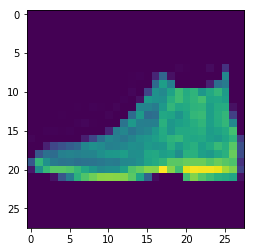

In [5]:
plt.imshow(test_imgs_raw[0])

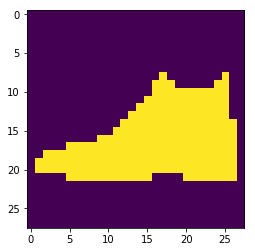

In [6]:
plt.imshow(test_imgs[0])

Since we are going to be using convolutions, we have to reshape data to 4 dimensions so that we don't get any errors because the shape won't be recognized.

In [7]:
train_imgs = train_imgs.reshape(60000, 28, 28, 1)
test_imgs = test_imgs.reshape(10000, 28, 28, 1)

## Creating the Model

In [8]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


## Creating Callback

I'll define a Callback that stops the training after the model has reached 91% accuracy.

In [11]:
class CustomCallback(tf.keras.callbacks.Callback):
    """ This is a class that defines a Custom Callback.
    
    It will be used to stop training when it has reached a certain level of accuracy
    
    References can be found on https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/callbacks/Callback
    """
    def on_epoch_end(self, epoch, logs):
        ''' This function sets a task to happen whenever en epoch has finished during training.
        
        It will be used to check if accuracy has reached a certain level, if so, stops the model training.
        
        References can be found on https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/callbacks/Callback#on_epoch_end
        
        Keyword arguments:
            epoch -- integer, index of epoch.
            logs -- dict, metric results for this training epoch,
                and for the validation epoch if validation is performed.
                Validation result keys are prefixed with val_.
        '''
        
        if(logs.get('accuracy') > 0.91):
          print(f'\n91% accuracy reached. Stopping training after {epoch + 1} epochs.')
          self.model.stop_training = True

## Fitting and Evaluating

Calling the fit function for 5 epochs and passing a CustomCallback instance.

After that, calling the evaluate function and printing evaluation data.

In [12]:
model.fit(train_imgs, train_labels, epochs=5, callbacks=[CustomCallback()])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 59s 991us/sample - loss: 0.4397 - accuracy: 0.8401
Epoch 2/5
60000/60000 [==============================] - 52s 875us/sample - loss: 0.3095 - accuracy: 0.8852
Epoch 3/5
60000/60000 [==============================] - 49s 822us/sample - loss: 0.2544 - accuracy: 0.9049
Epoch 4/5
59936/60000 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9194
91% accuracy reached. Stopping training after 4 epochs.
60000/60000 [==============================] - 48s 805us/sample - loss: 0.2119 - accuracy: 0.9194


In [13]:
evaluation = model.evaluate(test_imgs, test_labels, verbose=0)

print('loss:', evaluation[0], '- accuracy:', evaluation[1])

loss: 0.3381506258189678 - accuracy: 0.8819
